<h2>Imports and constants</h2>

In [1]:
import pandas as pd
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pycountry
%matplotlib inline

In [2]:
#data_path = 'data/'
data_path = 'C:\Users\Jakob\Desktop\RMIT\Practical Data Science\Assignment 2\\'

<h2>Functions</h2>

In [3]:
# def plot_cities(lons, lats):
#     plt.figure(figsize=(8,8))
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     #ax = plt.axes(projection=ccrs.EuroPP())
#     ax.stock_img()
#     #ax.coastlines()
#     plt.scatter(lons, lats,
#              color="blue", marker='o',
#              transform=ccrs.Geodetic(),
#              )
#     plt.show()

In [4]:
#plot_cities(df['Longitude'], df['Latitude'])

<h2>Merging world cities and cost of living index datasets</h2>

In [5]:
# Load world cities
cities = pd.read_csv(data_path + 'worldcitiespop.csv', sep=",")

C:\Users\Jakob\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Load cost of living index
coli = pd.read_csv(data_path + 'Cost_of_living_index.csv', sep=",")

In [7]:
# Parse original "City" column to "City" and "Country" columns
# TODO the USA countries are in "NY, New York" now.
coli["City"], coli["Country"] = coli["City"].str.lower().str.split(", ", 1).str

In [8]:
# Take only first 2000 most populated cities and drop any duplicates in city names.
new_cities = cities.sort_values("Population", ascending=False)[0:2000].drop_duplicates("City")

In [9]:
# Check how many cities we have now.
new_cities.shape

(1969, 7)

In [10]:
# Merge new cities and cost of living index datasets.
df = pd.merge(new_cities, coli, on="City", how="inner")
df.shape

(394, 15)

In [11]:
df = df[["City", "Country_y", "Population", "Latitude", "Longitude", "Cost of Living Plus Rent Index", "Local Purchasing Power Index"]]
df.rename(columns={"Country_y": "Country"}, inplace=True)

In [12]:
df.head(10)

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index
0,tokyo,japan,31480498.0,35.685000,139.751389,61.89,113.09
1,shanghai,china,14608512.0,31.045556,121.399722,42.68,72.16
2,karachi,pakistan,11627378.0,24.905600,67.082200,15.50,36.66
3,delhi,india,10928270.0,28.666667,77.216667,19.23,77.75
4,manila,philippines,10443877.0,14.604200,120.982200,27.46,40.04
5,moscow,russia,10381288.0,55.752222,37.615556,37.33,59.51
6,seoul,south korea,10323448.0,37.598500,126.978300,58.79,102.63
7,sao paulo,brazil,10021437.0,-23.473293,-46.665803,31.11,41.16
8,istanbul,turkey,9797536.0,41.018611,28.964722,25.24,50.13
9,lagos,nigeria,8789133.0,6.453056,3.395833,31.86,19.41


In [13]:
df.shape

(394, 7)

In [14]:
df.dtypes

City                               object
Country                            object
Population                        float64
Latitude                          float64
Longitude                         float64
Cost of Living Plus Rent Index    float64
Local Purchasing Power Index      float64
dtype: object

<h2>Temperature</h2>

In [15]:
temperature = pd.read_csv(data_path + 'temperatures.csv', sep=',', decimal='.')

In [16]:
temperature['dt'] = pd.to_datetime(temperature['dt'])

In [17]:
temperature.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In [18]:
# Take average temperature for year 2012 (newest).
temperature['year'] = temperature.dt.dt.year
new_temperatures = temperature[temperature.year == 2012][['City', 'AverageTemperature']].groupby('City', as_index=False).mean()
new_temperatures["City"] = new_temperatures["City"].str.lower()
#new_temperatures["City"] = new_temperatures["City"].apply(lambda ct: unidecode.unidecode_expect_nonascii(str(ct)))

In [19]:
new_temperatures.head(10)

,City,AverageTemperature
0,a coruña,13.625667
1,aachen,9.788500
2,aalborg,8.399833
3,aba,27.253500
4,abadan,26.607833
5,abakaliki,27.253500
6,abakan,-0.697333
7,abbotsford,7.851083
8,abengourou,27.032583
9,abeokuta,26.996333


In [20]:
# Print cities throwed away due to lack of ttemperature information.
tmp = pd.merge(df, new_temperatures, on="City", how='left')
tmp[tmp["AverageTemperature"].isna()]

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature
7,sao paulo,brazil,10021437.0,-23.473293,-46.665803,31.11,41.16,NaN
16,bogota,colombia,7102602.0,4.649178,-74.062827,24.44,37.44,NaN
59,brasilia,brazil,2207812.0,-15.783333,-47.916667,29.76,63.24,NaN
64,medellin,colombia,2000001.0,6.251840,-75.563591,23.09,34.02,NaN
127,rostov-na-donu,russia,1074495.0,47.231350,39.723284,22.00,41.38,NaN
171,merida,mexico,717196.0,20.966667,-89.616667,18.19,40.29,NaN
190,queretaro,mexico,611803.0,20.600000,-100.383333,20.72,57.83,NaN
204,dusseldorf,germany,577139.0,51.216667,6.766667,53.99,115.58,NaN
210,malaga,spain,557875.0,36.726666,-4.434802,36.24,87.90,NaN
216,cancun,mexico,542156.0,21.166667,-86.833333,21.39,53.68,NaN


In [21]:
df = pd.merge(df, new_temperatures, on="City", how='inner')

In [22]:
df.head(10)

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature
0,tokyo,japan,31480498.0,35.685000,139.751389,61.89,113.09,13.113250
1,shanghai,china,14608512.0,31.045556,121.399722,42.68,72.16,16.474500
2,karachi,pakistan,11627378.0,24.905600,67.082200,15.50,36.66,26.749833
3,delhi,india,10928270.0,28.666667,77.216667,19.23,77.75,25.889417
4,manila,philippines,10443877.0,14.604200,120.982200,27.46,40.04,27.336417
5,moscow,russia,10381288.0,55.752222,37.615556,37.33,59.51,5.200917
6,seoul,south korea,10323448.0,37.598500,126.978300,58.79,102.63,11.227083
7,istanbul,turkey,9797536.0,41.018611,28.964722,25.24,50.13,14.972583
8,lagos,nigeria,8789133.0,6.453056,3.395833,31.86,19.41,27.153167
9,jakarta,indonesia,8540306.0,-6.174444,106.829444,29.39,28.95,27.362667


In [23]:
df.shape

(376, 8)

<h2>Liveability</h2>

In [24]:
liveability = pd.read_csv(data_path + 'liveability.csv', sep=',')

In [25]:
liveability["City"] = liveability.City.str.lower()
liveability = liveability[["City", "Movehub Rating"]]
liveability.rename(columns={"Movehub Rating": "Liveability"}, inplace=True)

In [26]:
liveability.head()

,City,Liveability
0,caracas,65.18
1,johannesburg,84.08
2,fortaleza,80.17
3,saint louis,85.25
4,mexico city,75.07


In [27]:
df = pd.merge(df, liveability, on="City", how='inner')

In [28]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability
0,tokyo,japan,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00
1,shanghai,china,14608512.0,31.045556,121.399722,42.68,72.16,16.474500,75.69
2,karachi,pakistan,11627378.0,24.905600,67.082200,15.50,36.66,26.749833,67.81
3,delhi,india,10928270.0,28.666667,77.216667,19.23,77.75,25.889417,77.12
4,manila,philippines,10443877.0,14.604200,120.982200,27.46,40.04,27.336417,68.31


In [29]:
df.shape

(175, 9)

<h2>Unemployment rate</h2>

In [30]:
unemployment = pd.read_csv(data_path + 'unemployment.csv', sep=',', decimal='.')

In [31]:
# All the indicators, we choose 3296 - Unemployment rate (% of total labor force) (WEO)
unemployment[["Indicator Id", "Indicator"]].drop_duplicates()

,Indicator Id,Indicator
0,346,Gross national savings (% of GDP)
1,347,"Inflation, average consumer prices"
2,352,Population (WEO)
3,354,General government total expenditure
4,355,General government net lending/borrowing
5,357,General government primary net lending/borrowing
6,359,General government gross debt
7,360,Gross domestic product corresponding to fiscal...
8,2777,General government total expenditure
9,2779,General government net lending/borrowing


In [32]:
# We are interested only in 3296 Indicator ID. We use current year 2019.
# We also drop observations with missing value.
unemployment = unemployment[unemployment["Indicator Id"] == 3296][["Country Name", "2019"]].dropna()
unemployment.rename(columns={"Country Name": "Country", "2019": "Unemployment rate"}, inplace=True)
unemployment["Country"] = unemployment["Country"].str.lower()

In [33]:
df = pd.merge(df, unemployment, on="Country", how="inner")

In [34]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate
0,tokyo,japan,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00,2.867
1,shanghai,china,14608512.0,31.045556,121.399722,42.68,72.16,16.474500,75.69,4.000
2,karachi,pakistan,11627378.0,24.905600,67.082200,15.50,36.66,26.749833,67.81,6.140
3,lahore,pakistan,6312576.0,31.549722,74.343611,16.10,39.75,24.869417,67.32,6.140
4,manila,philippines,10443877.0,14.604200,120.982200,27.46,40.04,27.336417,68.31,5.500


In [35]:
df.shape

(119, 10)

<h2>Freedom</h2>

In [36]:
freedom = pd.read_csv(data_path + 'Happiness.csv', sep =',', decimal='.')

In [37]:
freedom = freedom[['Country', 'Freedom']]
freedom['Country'] = freedom['Country'].str.lower()

In [38]:
df = pd.merge(df, freedom, on='Country', how='inner')

In [39]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate,Freedom
0,tokyo,japan,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00,2.867,0.505626
1,shanghai,china,14608512.0,31.045556,121.399722,42.68,72.16,16.474500,75.69,4.000,0.472788
2,karachi,pakistan,11627378.0,24.905600,67.082200,15.50,36.66,26.749833,67.81,6.140,0.235215
3,lahore,pakistan,6312576.0,31.549722,74.343611,16.10,39.75,24.869417,67.32,6.140,0.235215
4,manila,philippines,10443877.0,14.604200,120.982200,27.46,40.04,27.336417,68.31,5.500,0.585215


In [40]:
df.shape

(119, 11)

<h2>Wages</h2>

In [41]:
wages = pd.read_csv(data_path + 'average_wages.csv', sep=',', decimal='.')

In [42]:
# We take data from 2016 (newest)
wages = wages[wages['TIME'] == 2016].groupby('LOCATION', as_index=False).mean()

In [43]:
# Transform country code to actual country name.
wages["Country"] = wages["LOCATION"].apply(lambda country_code: pycountry.countries.get(alpha_3=country_code).name.lower())

In [44]:
wages.rename(columns = {'Value':'Wages'}, inplace=True)

In [45]:
wages = wages[['Country', 'Wages']]

In [46]:
df = pd.merge(df, wages, on='Country', how='inner')

In [47]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate,Freedom,Wages
0,tokyo,japan,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00,2.867,0.505626,39113
1,london,united kingdom,7421228.0,51.514125,-0.093689,76.10,100.22,10.255292,100.00,4.179,0.508190,42835
2,birmingham,united kingdom,984336.0,52.466667,-1.916667,48.38,106.94,14.147750,80.85,4.179,0.508190,42835
3,glasgow,united kingdom,610271.0,55.833333,-4.250000,48.04,121.47,8.077083,84.23,4.179,0.508190,42835
4,belfast,united kingdom,585994.0,54.583333,-5.933333,43.58,100.69,9.268917,82.15,4.179,0.508190,42835


In [48]:
df.shape

(80, 12)

In [49]:
#plot_cities(df['Longitude'], df['Latitude'])

In [50]:
df = df.rename(columns={'AverageTemperature':'Average Temperature', 'Unemployment rate': 'Unemployment Rate'})

<h2>Data Exploration</h2>

In [51]:
df.dtypes

City                               object
Country                            object
Population                        float64
Latitude                          float64
Longitude                         float64
Cost of Living Plus Rent Index    float64
Local Purchasing Power Index      float64
Average Temperature               float64
Liveability                       float64
Unemployment Rate                 float64
Freedom                           float64
Wages                               int64
dtype: object

In [52]:
df['City'].describe()

count           80
unique          78
top       hamilton
freq             2
Name: City, dtype: object

In [53]:
df['City'].unique()

array(['tokyo', 'london', 'birmingham', 'glasgow', 'belfast', 'liverpool',
       'leeds', 'edinburgh', 'bristol', 'manchester', 'leicester',
       'nottingham', 'aberdeen', 'toronto', 'montreal', 'vancouver',
       'calgary', 'ottawa', 'edmonton', 'hamilton', 'victoria', 'regina',
       'santiago', 'sydney', 'melbourne', 'brisbane', 'perth', 'adelaide',
       'gold coast', 'canberra', 'berlin', 'hamburg', 'munich', 'cologne',
       'frankfurt', 'stuttgart', 'dresden', 'aachen', 'madrid',
       'barcelona', 'valencia', 'rome', 'milan', 'naples', 'florence',
       'paris', 'marseille', 'lyon', 'toulouse', 'nice', 'strasbourg',
       'budapest', 'warsaw', 'vienna', 'stockholm', 'copenhagen',
       'dublin', 'cork', 'brussels', 'oslo', 'bergen', 'stavanger',
       'amsterdam', 'rotterdam', 'utrecht', 'athens', 'jerusalem',
       'haifa', 'auckland', 'christchurch', 'wellington', 'helsinki',
       'vilnius', 'lisbon', 'porto', 'zurich', 'geneva', 'ljubljana'],
      dtype=objec

In [54]:
(df['City'].value_counts() == 2).head() # Check for Cities that appear twice

hamilton     True
london       True
warsaw      False
regina      False
belfast     False
Name: City, dtype: bool

In [55]:
df[df['City'] == 'hamilton']

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages
20,hamilton,canada,653637.0,43.25,-79.833333,44.46,127.16,12.31025,81.34,6.206,0.611101,48403
69,hamilton,new zealand,653637.0,43.25,-79.833333,48.81,114.79,12.31025,81.34,4.423,0.614062,39397


In [56]:
df[df['City'] == 'london']

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages
1,london,united kingdom,7421228.0,51.514125,-0.093689,76.10,100.22,10.255292,100.0,4.179,0.508190,42835
13,london,canada,7421228.0,51.514125,-0.093689,42.08,118.79,10.255292,100.0,6.206,0.611101,48403


In [57]:
df['Country'].describe()

count                 80
unique                26
top       united kingdom
freq                  12
Name: Country, dtype: object

In [58]:
df['Country'].unique()

array(['japan', 'united kingdom', 'canada', 'chile', 'australia',
       'germany', 'spain', 'italy', 'france', 'hungary', 'poland',
       'austria', 'sweden', 'denmark', 'ireland', 'belgium', 'norway',
       'netherlands', 'greece', 'israel', 'new zealand', 'finland',
       'lithuania', 'portugal', 'switzerland', 'slovenia'], dtype=object)

Text(0,0.5,'Amount of cities in the respective country')

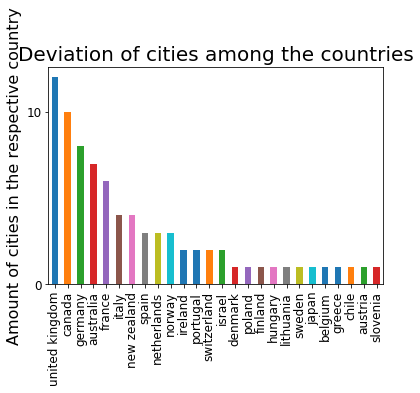

In [59]:
plt.rc('font', size=40)
df['Country'].value_counts().plot(kind='bar', fontsize=12)
plt.title('Deviation of cities among the countries', fontsize=20)
plt.ylabel('Amount of cities in the respective country', fontsize=16)

In [60]:
pd.set_option('display.float_format', '{:.2f}'.format) #set format of displayed values
df['Population'].describe()

count         80.00
mean     1578885.34
std      3682693.56
min       173535.00
25%       359742.25
50%       653637.00
75%      1400580.25
max     31480498.00
Name: Population, dtype: float64

Text(0.5,1,'Density of the population')

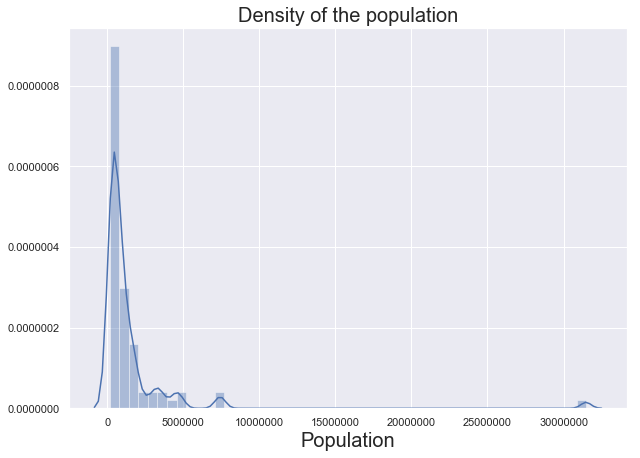

In [86]:
import seaborn as sns
ax = plt.subplot()
ax.ticklabel_format(style='plain')
sns.distplot(df['Population'])
sns.set(rc={'figure.figsize':(10,7)})
plt.rcParams["axes.labelsize"] = 20
plt.title('Density of the population', fontsize=20)

In [62]:
df['Cost of Living Plus Rent Index'].describe()

count   80.00
mean    53.55
std     12.09
min     30.63
25%     46.59
50%     52.20
75%     57.70
max     97.39
Name: Cost of Living Plus Rent Index, dtype: float64

Text(0.5,1,'Density of Cost of Living Plus Rent Index')

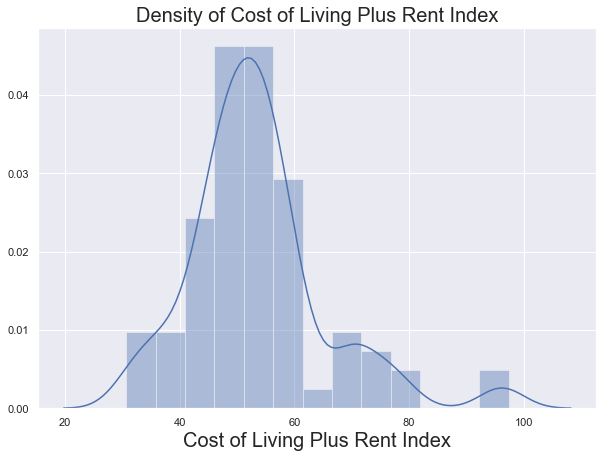

In [63]:
sns.distplot(df['Cost of Living Plus Rent Index'])
plt.title('Density of Cost of Living Plus Rent Index', fontsize=20)

In [64]:
df['Local Purchasing Power Index'].describe()

count    80.00
mean    106.63
std      23.02
min      51.83
25%      95.90
50%     109.34
75%     121.35
max     153.77
Name: Local Purchasing Power Index, dtype: float64

Text(0.5,1,'Density of Local Purchasing Power Index')

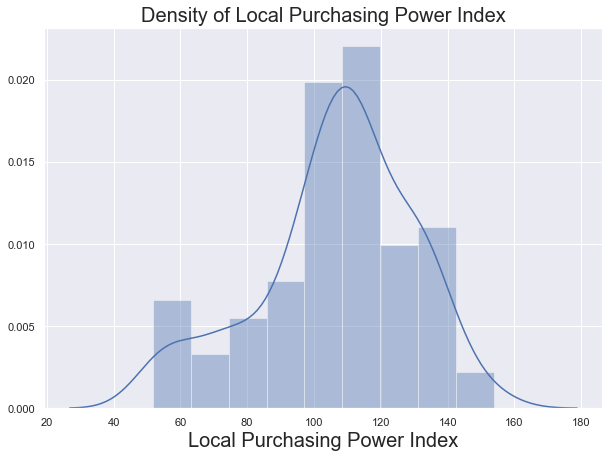

In [65]:
sns.distplot(df['Local Purchasing Power Index'])
plt.title('Density of Local Purchasing Power Index', fontsize=20)

In [66]:
df['Average Temperature'].describe()

count   80.00
mean    11.14
std      4.51
min      2.30
25%      8.72
50%     10.04
75%     13.15
max     22.20
Name: Average Temperature, dtype: float64

Text(0.5,1,'Density of Average Temperature')

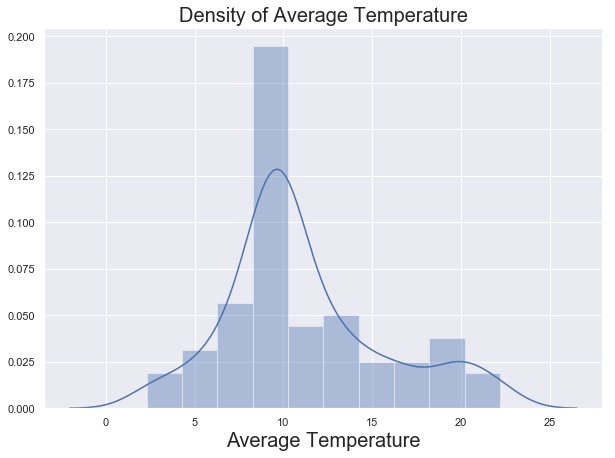

In [67]:
sns.distplot(df['Average Temperature'])
plt.title('Density of Average Temperature', fontsize=20)

In [68]:
df['Liveability'].describe()

count    80.00
mean     83.19
std       5.20
min      72.45
25%      80.82
50%      82.33
75%      84.78
max     100.00
Name: Liveability, dtype: float64

Text(0.5,1,'Density of Liveability')

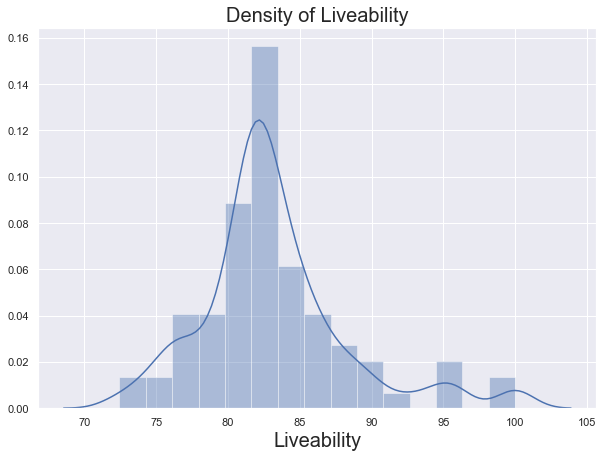

In [87]:
sns.distplot(df['Liveability'])
plt.title('Density of Liveability', fontsize=20)

In [70]:
df['Unemployment Rate'].describe()

count   80.00
mean     5.82
std      2.95
min      2.82
25%      3.97
50%      5.02
75%      6.22
max     18.07
Name: Unemployment Rate, dtype: float64

Text(0.5,1,'Density of Unemployment Rate')

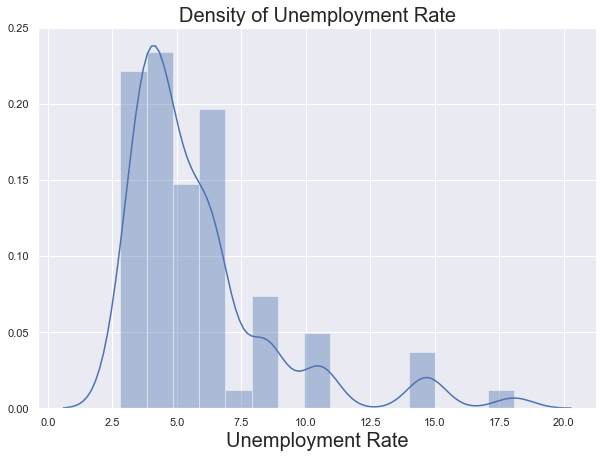

In [71]:
sns.distplot(df['Unemployment Rate'])
plt.title('Density of Unemployment Rate', fontsize=20)

In [72]:
df['Freedom'].describe()

count   80.00
mean     0.52
std      0.12
min      0.10
25%      0.50
50%      0.56
75%      0.61
max      0.64
Name: Freedom, dtype: float64

Text(0.5,1,'Density of Freedom')

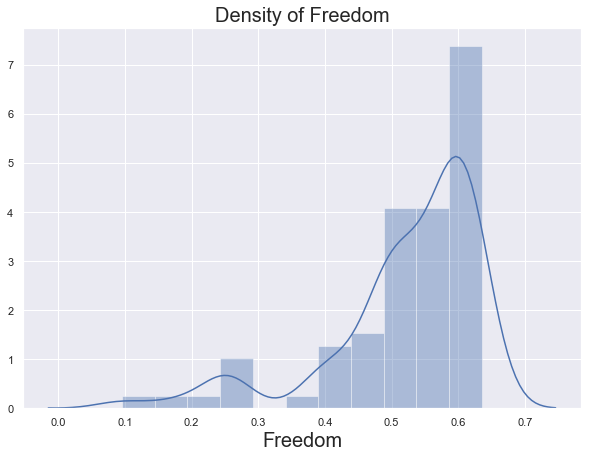

In [73]:
sns.distplot(df['Freedom'])
plt.title('Density of Freedom', fontsize=20)

In [74]:
df['Wages'].describe()

count      80.00
mean    43706.18
std      8291.86
min     21711.00
25%     39397.00
50%     42992.00
75%     48403.00
max     60124.00
Name: Wages, dtype: float64

Text(0.5,1,'Density of Wages in USD')

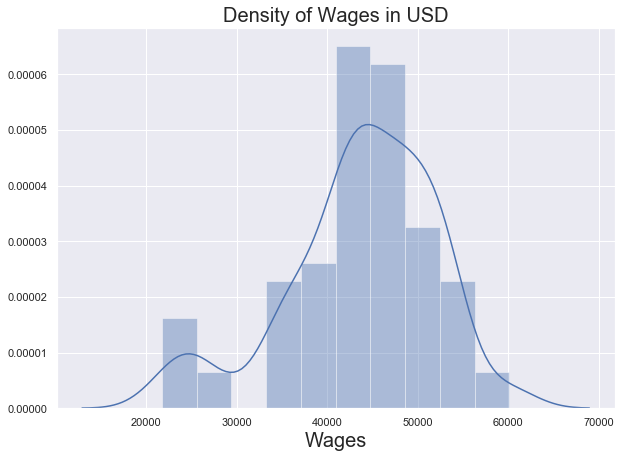

In [75]:
sns.distplot(df['Wages'])
plt.title('Density of Wages in USD', fontsize=20)

Text(0.5,0,'City')

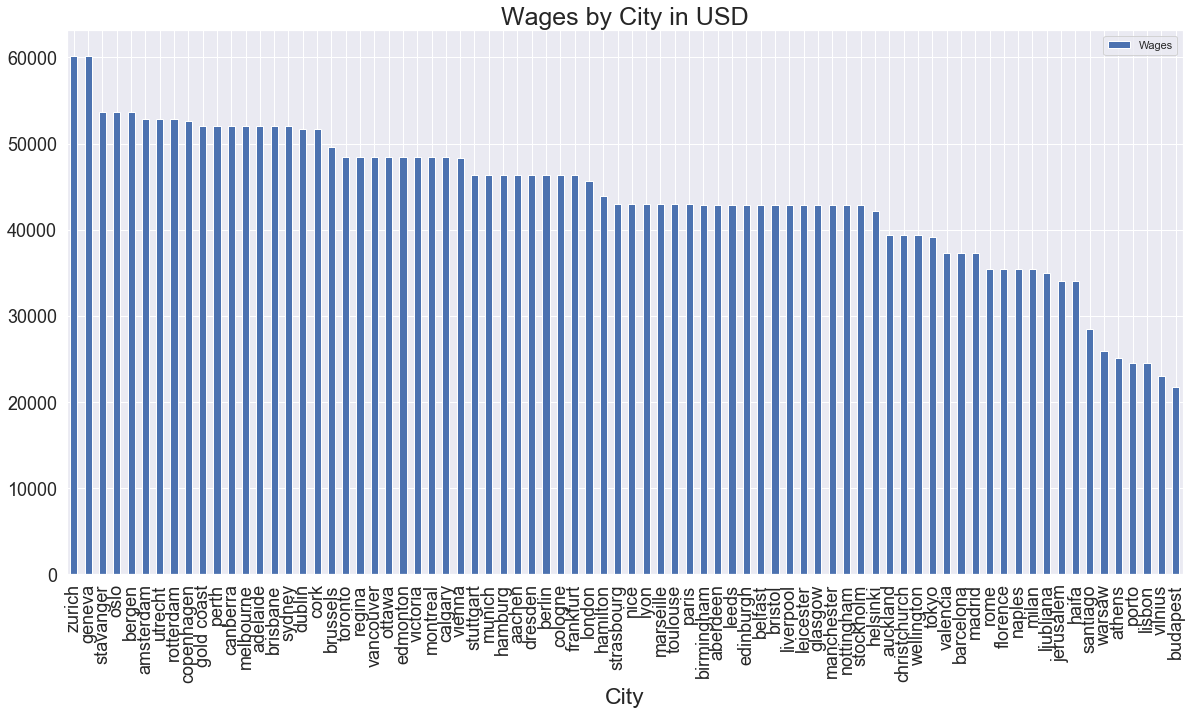

In [76]:
df[['City', 'Wages']].groupby('City').mean().sort_values('Wages', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.title('Wages by City in USD', fontsize=25)
plt.xlabel('City', fontsize=23)

Text(0.5,0,'City')

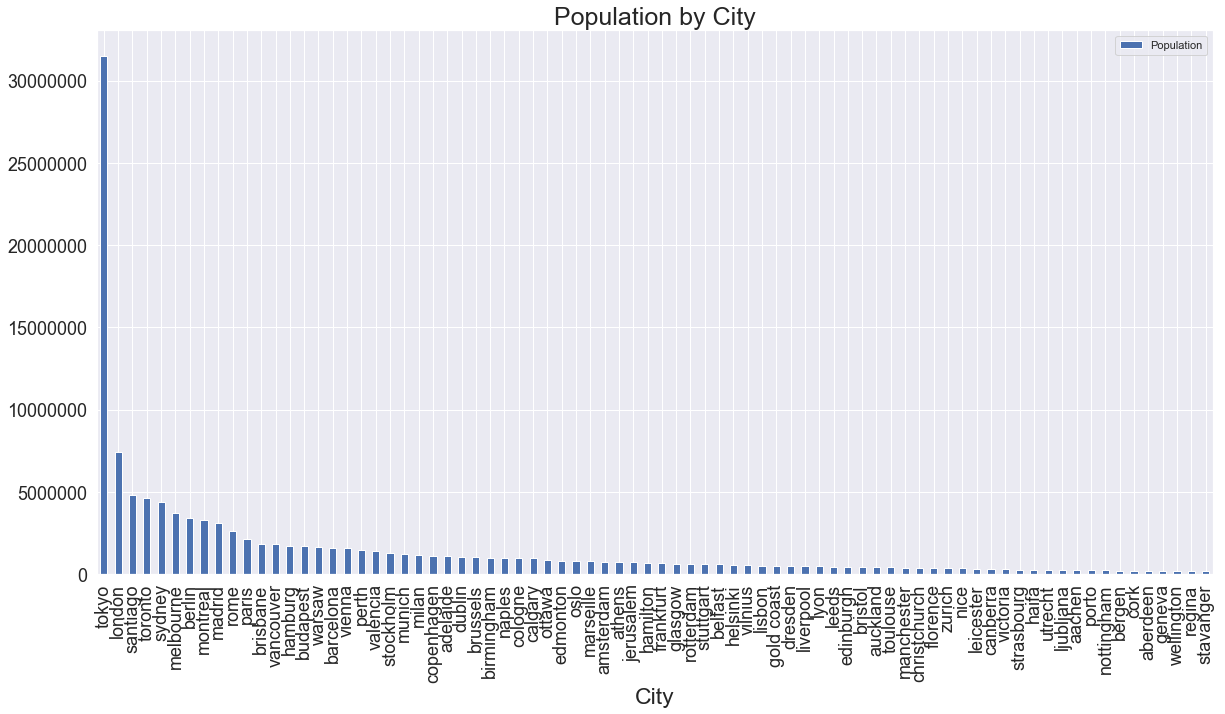

In [77]:
df[['City','Population']].groupby('City').mean().sort_values('Population', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Population by City', fontsize=25)
plt.xlabel('City', fontsize=23)

Text(0.5,0,'Country')

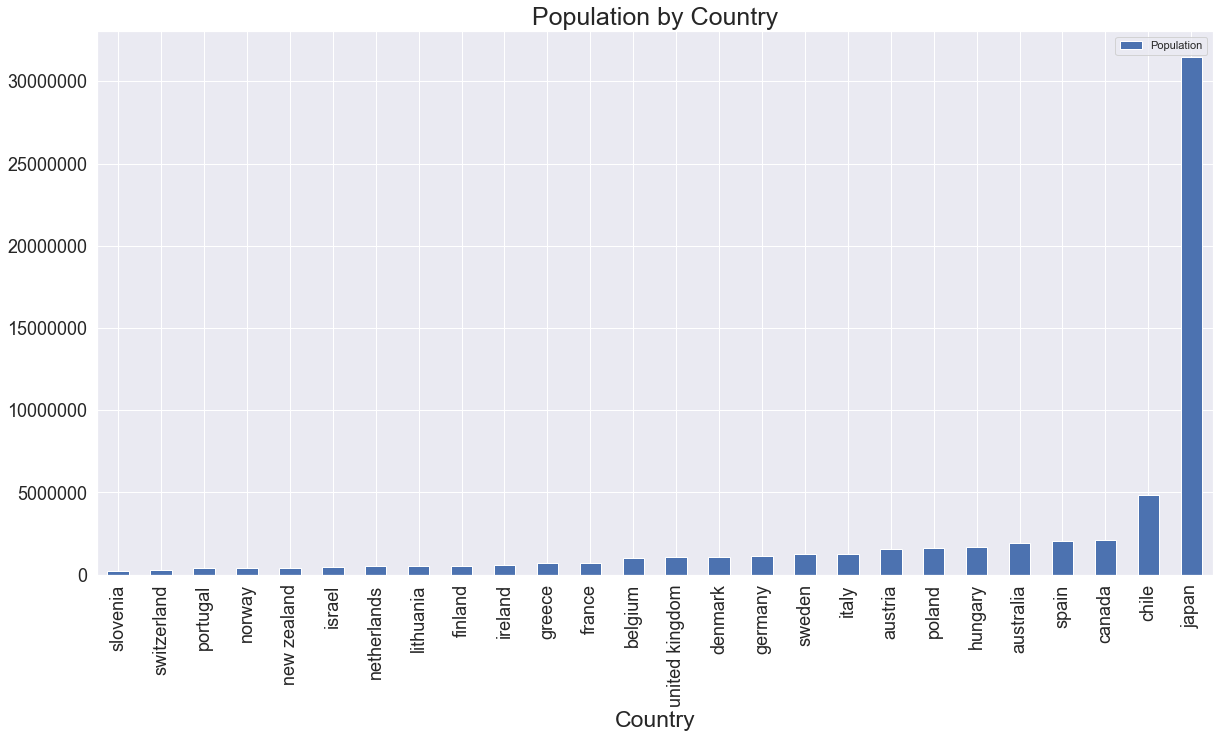

In [78]:
df[['Country', 'Population']].groupby('Country').mean().sort_values('Population', ascending=True).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Population by Country', fontsize=25)
plt.xlabel('Country', fontsize=23)

Text(0.5,0,'Cost of Living Plus Rent Index')

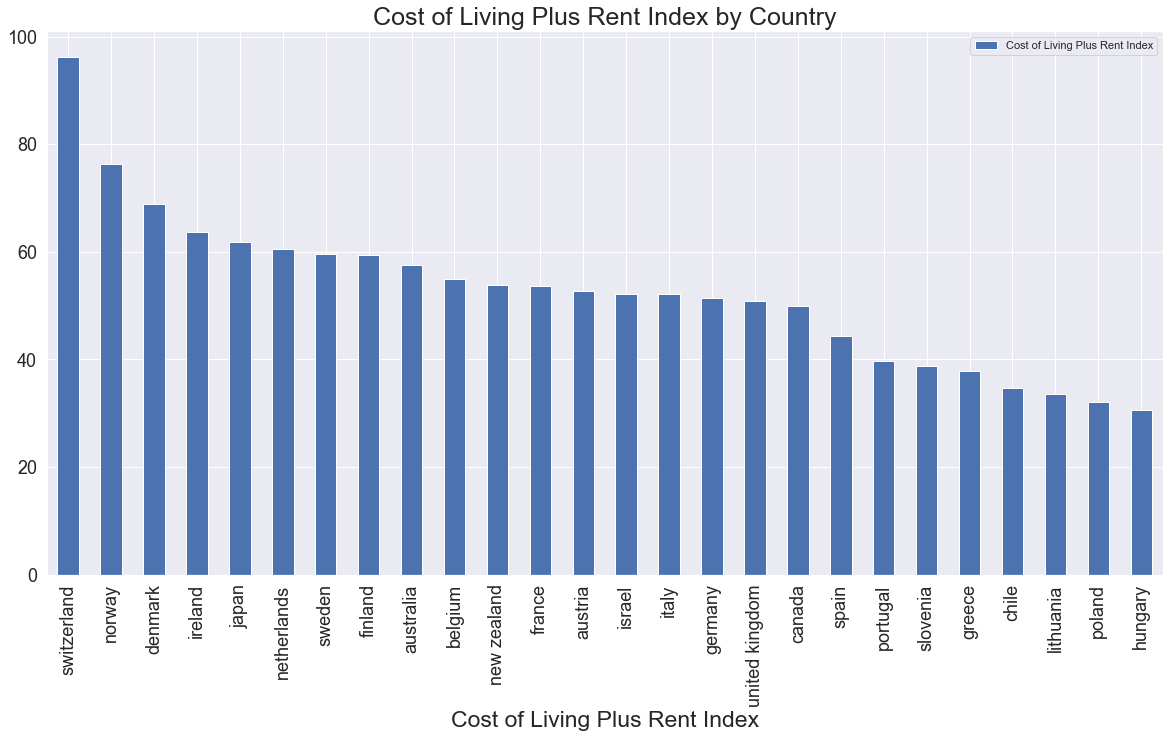

In [79]:
df[['Country', 'Cost of Living Plus Rent Index']].groupby('Country').mean().sort_values('Cost of Living Plus Rent Index', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Cost of Living Plus Rent Index by Country', fontsize=25)
plt.xlabel('Cost of Living Plus Rent Index', fontsize=23)

Text(0.5,0,'Local Purchasing Power Index')

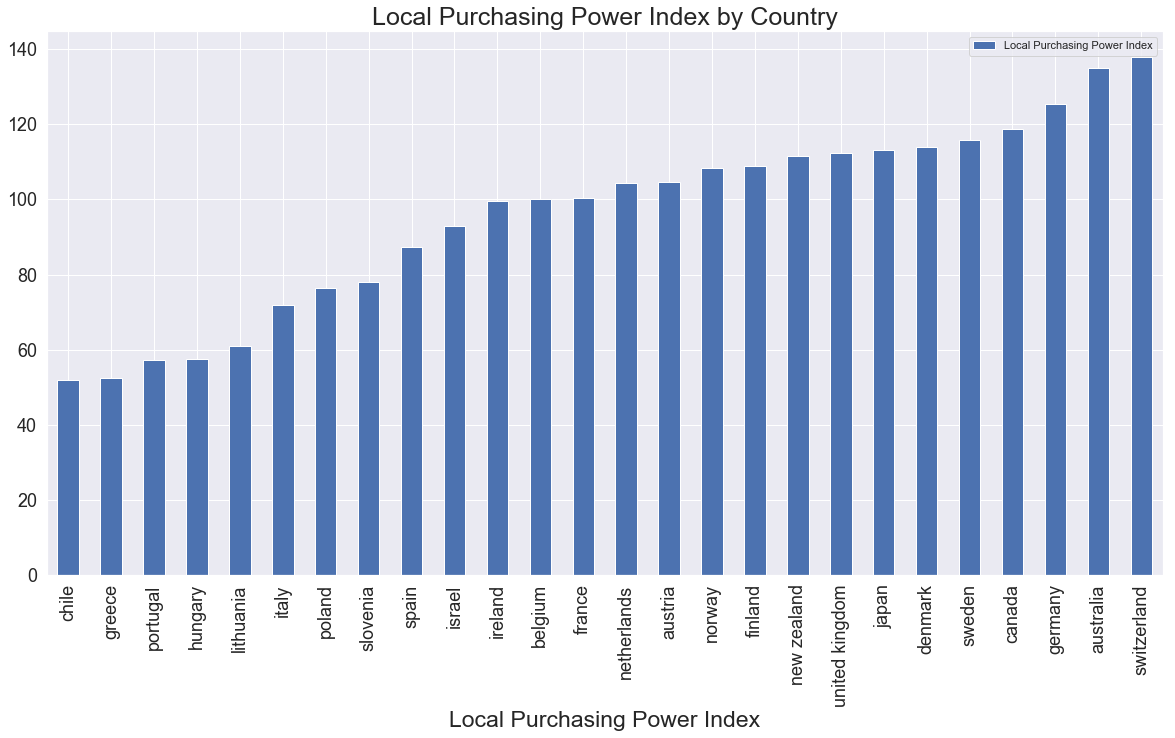

In [80]:
df[['Country', 'Local Purchasing Power Index']].groupby('Country').mean().sort_values('Local Purchasing Power Index', ascending=True).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Local Purchasing Power Index by Country', fontsize=25)
plt.xlabel('Local Purchasing Power Index', fontsize=23)

Text(0.5,0,'Average Temperature')

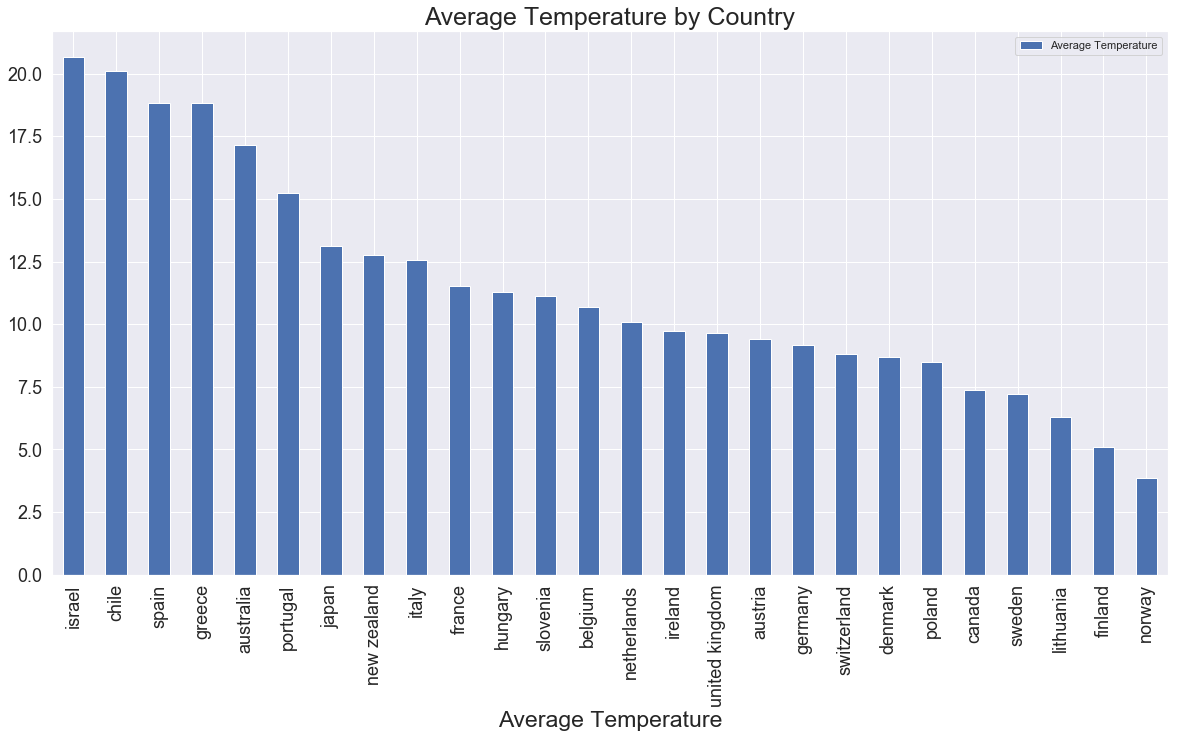

In [81]:
df[['Country', 'Average Temperature']].groupby('Country').mean().sort_values('Average Temperature', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Average Temperature by Country', fontsize=25)
plt.xlabel('Average Temperature', fontsize=23)

Text(0.5,0,'Unemployment Rate')

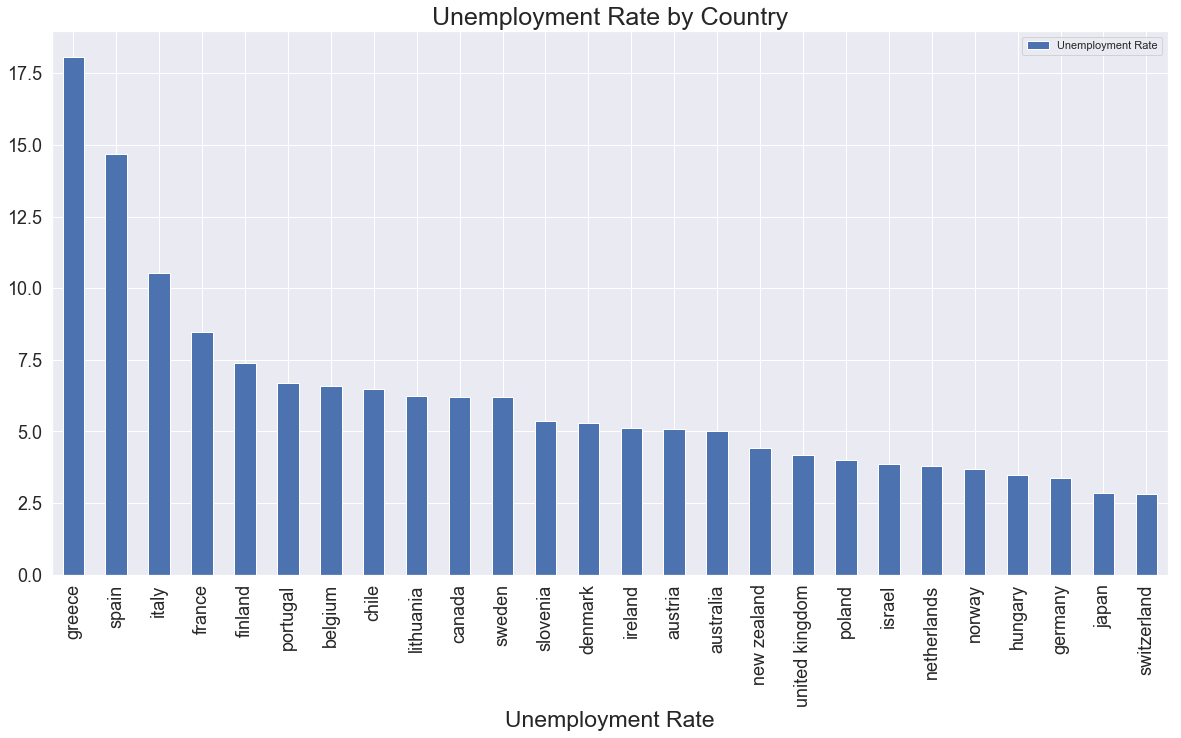

In [82]:
df[['Country', 'Unemployment Rate']].groupby('Country').mean().sort_values('Unemployment Rate', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Unemployment Rate by Country', fontsize=25)
plt.xlabel('Unemployment Rate', fontsize=23)

Text(0.5,0,'Freedom')

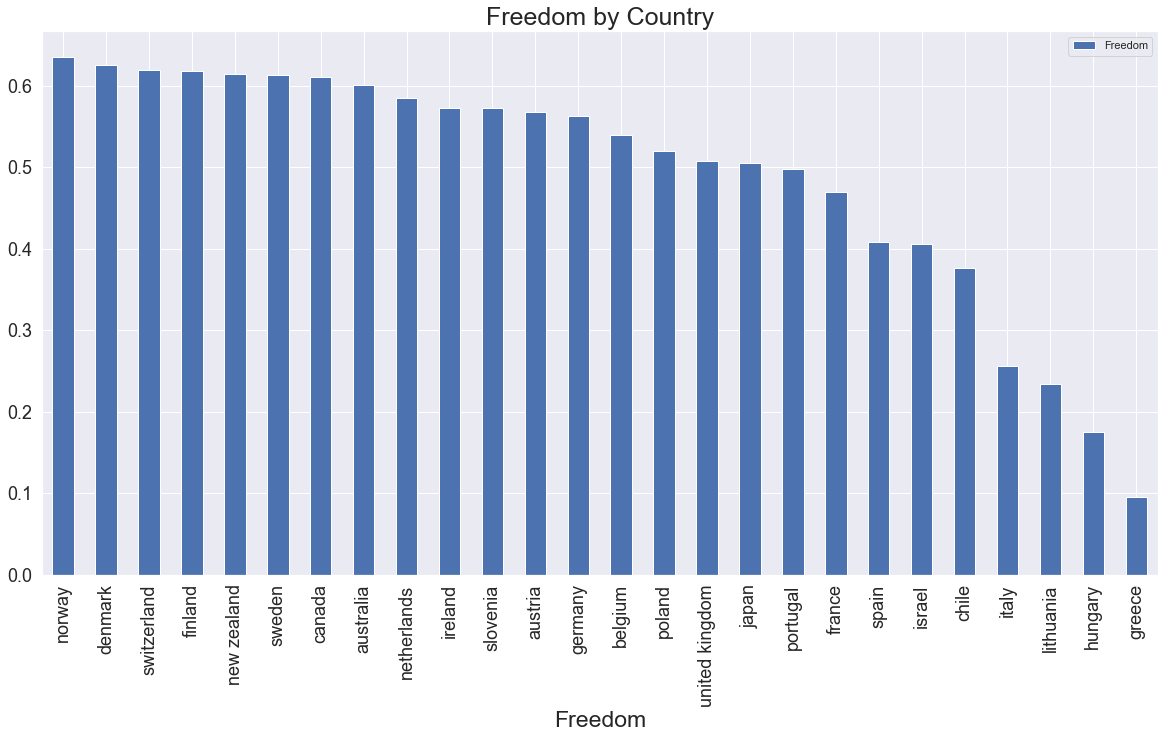

In [83]:
df[['Country', 'Freedom']].groupby('Country').mean().sort_values('Freedom', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Freedom by Country', fontsize=25)
plt.xlabel('Freedom', fontsize=23)

Text(0.5,0,'Wages')

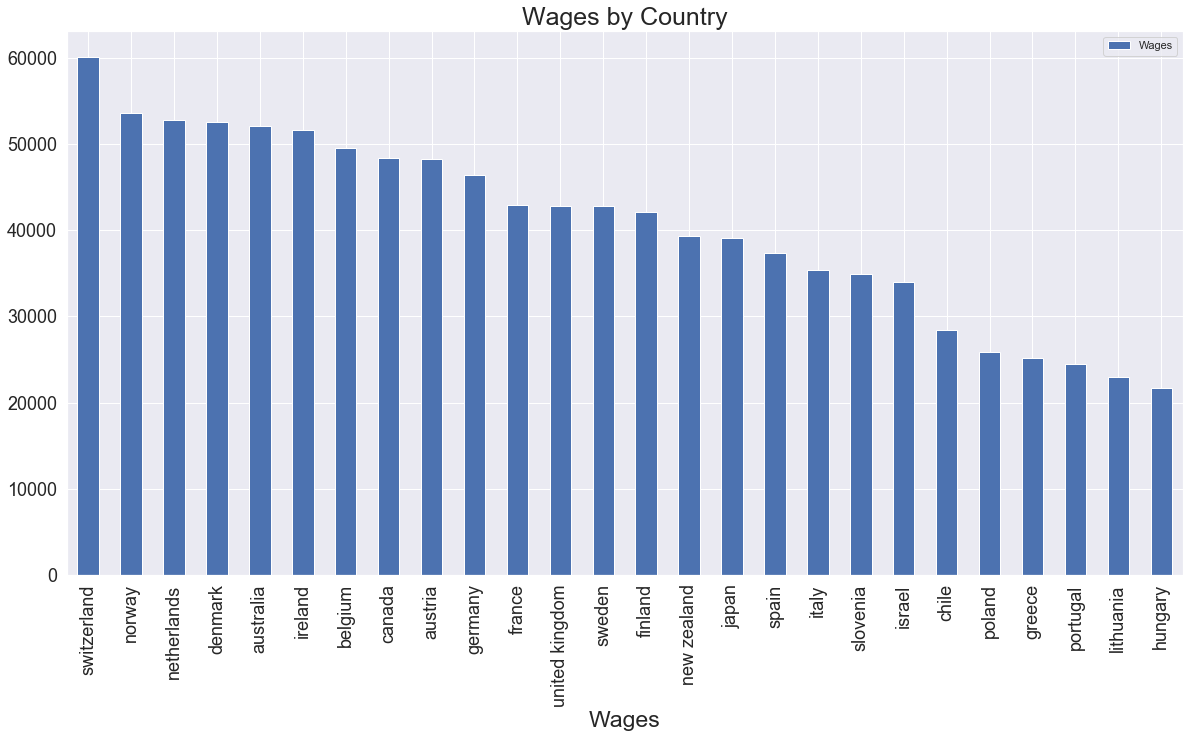

In [84]:
df[['Country', 'Wages']].groupby('Country').mean().sort_values('Wages', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Wages by Country', fontsize=25)
plt.xlabel('Wages', fontsize=23)

Text(0.5,0,'Liveability')

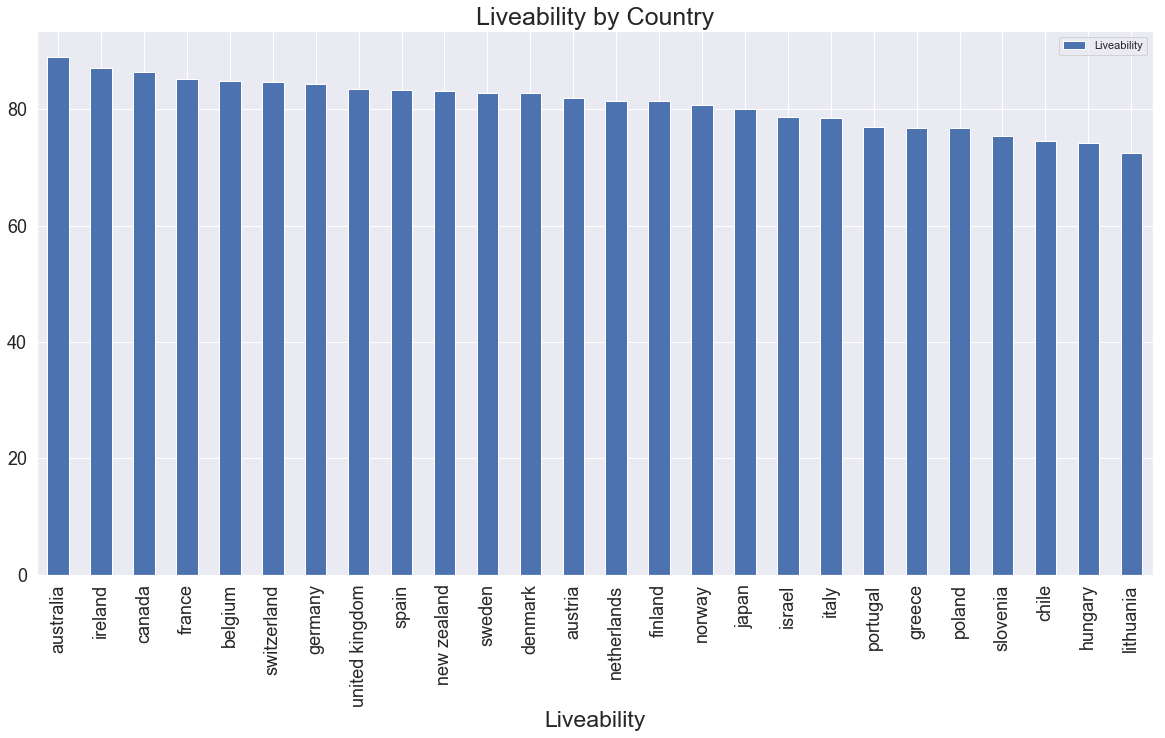

In [85]:
df[['Country', 'Liveability']].groupby('Country').mean().sort_values('Liveability', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Liveability by Country', fontsize=25)
plt.xlabel('Liveability', fontsize=23)